In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from redist import modifier
from redist import plot
from knunu_utils import * 

# Reinterpreting $B \to K \nu \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of one kinematic variable: $q^2$.

We use $q^2$ also as the fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [2]:
binning = np.linspace(0.0, 22.9, 13) 
bin_cents = (binning[:-1] + binning[1:])/2

## Generate some SM samples

In [3]:
SMsamples = 50000

p = analysis().parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=22.90)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

pdf = eos.SignalPDF.make('B^-->K^-nunu::dGamma/dq2', p, k, o)
obs = eos.Observable.make('B->Knunu::BR', p, k, o)
SMBR = obs.evaluate()

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

/home/lorenz/venv_redist/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Smear samples with Gaussian resolution function and apply efficiency


In [4]:
null_samples_smeared = np.random.normal(null_samples, 1.0, null_samples.shape)
null_samples_smeared = np.abs(null_samples_smeared)

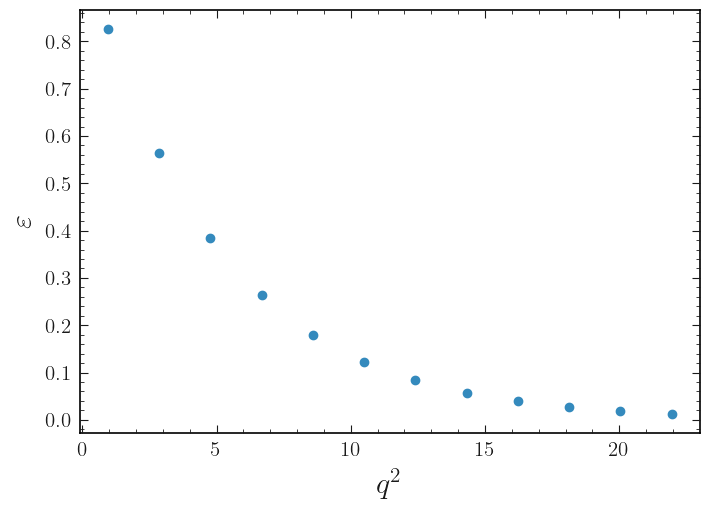

In [5]:
plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

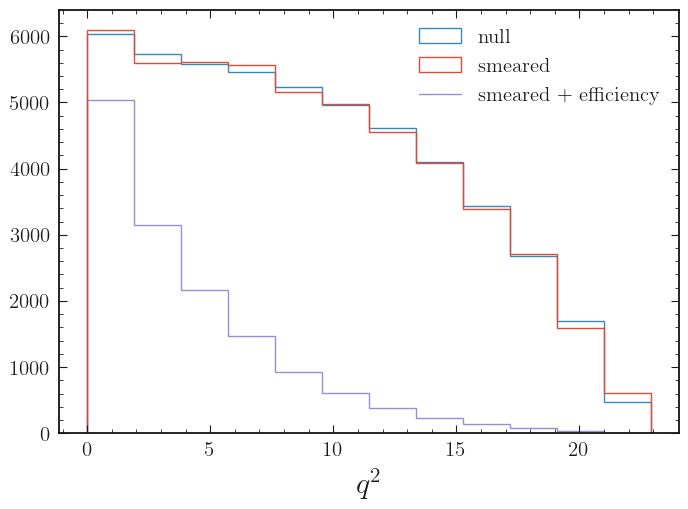

In [6]:
plt.hist(null_samples, binning, histtype='step', label='null')
null_yields, _, _ = plt.hist(null_samples_smeared, binning, histtype='step', label='smeared')
null_yields *= efficiency(bin_cents)
plt.stairs(null_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$')
plt.legend()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [7]:
p['sbnunu::Re{cVL}'].set(5.0)
p['sbnunu::Re{cSL}'].set(3.0)
p['sbnunu::Re{cTL}'].set(2.0)

BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

### Smear samples with Gaussian resolution function and apply efficiency


In [8]:
alt_samples_smeared = np.random.normal(alt_samples, 1.0, alt_samples.shape)
alt_samples_smeared = np.abs(alt_samples_smeared)

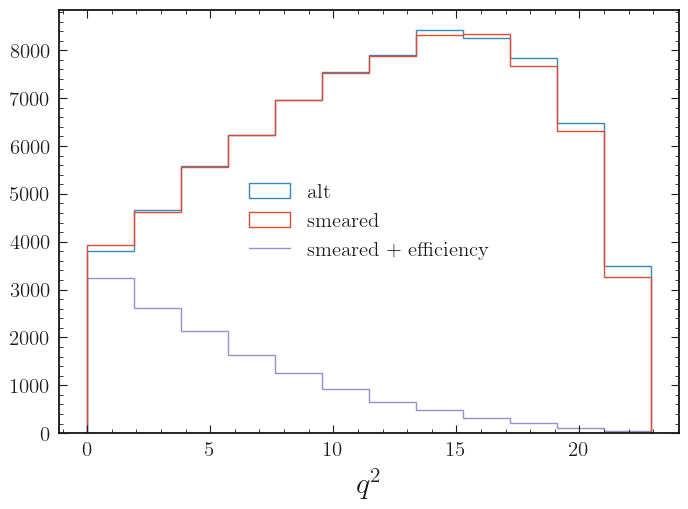

In [9]:
plt.hist(alt_samples, binning, histtype='step', label='alt')
alt_yields, _, _ = plt.hist(alt_samples_smeared, binning, histtype='step', label='smeared')
alt_yields *= efficiency(bin_cents)
plt.stairs(alt_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$')
plt.legend()

## Set up the mapping distribution

In [10]:
mapping_dist = np.histogram2d(null_samples.flatten(), null_samples_smeared.flatten(), bins=binning)[0].T
mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

## Set up the custom modifier

In [11]:
null = null_pred()
alt = alt_pred()

In [12]:
ana = analysis()
cvl = ana.parameters['sbnunu::Re{cVL}'         ].evaluate()
csl = ana.parameters['sbnunu::Re{cSL}'         ].evaluate()
ctl = ana.parameters['sbnunu::Re{cTL}'         ].evaluate()
fp0 = ana.parameters['B->K::alpha^f+_0@BSZ2015'].evaluate()
fp1 = ana.parameters['B->K::alpha^f+_1@BSZ2015'].evaluate()
fp2 = ana.parameters['B->K::alpha^f+_2@BSZ2015'].evaluate()
f01 = ana.parameters['B->K::alpha^f0_1@BSZ2015'].evaluate()
f02 = ana.parameters['B->K::alpha^f0_2@BSZ2015'].evaluate()
fT0 = ana.parameters['B->K::alpha^fT_0@BSZ2015'].evaluate()
fT1 = ana.parameters['B->K::alpha^fT_1@BSZ2015'].evaluate()
fT2 = ana.parameters['B->K::alpha^fT_2@BSZ2015'].evaluate()

In [13]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

,0,1,2,3,4,5,6,7
0,0.000109,0.000696,0.000979,0.000775,0.001303,0.000088,0.000565,0.000760
1,0.000696,0.009307,0.021609,0.005688,0.010247,0.000392,0.006202,0.014710
2,0.000979,0.021609,0.067185,0.008526,0.017058,0.000097,0.011229,0.042544
3,0.000775,0.005688,0.008526,0.006233,0.011288,0.000612,0.004714,0.006588
4,0.001303,0.010247,0.017058,0.011288,0.022037,0.000978,0.008112,0.012782
5,0.000088,0.000392,0.000097,0.000612,0.000978,0.000473,0.003446,0.005830
6,0.000565,0.006202,0.011229,0.004714,0.008112,0.003446,0.031871,0.061918
7,0.000760,0.014710,0.042544,0.006588,0.012782,0.005830,0.061918,0.144128


In [14]:
new_params = {
                'cvl'   :{'inits': (6.0,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.1,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.1,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'FF'    :{'inits': (fp0, fp1, fp2, f01, f02, fT0, fT1, fT2), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [binning.tolist()])

(<Figure size 1400x500 with 2 Axes>,
 array([<Axes: title={'center': 'distributions'}, xlabel='$q^2$ [GeV$^2$]'>,
        <Axes: title={'center': 'weights'}, xlabel='$q^2$ [GeV$^2$]'>],
       dtype=object))

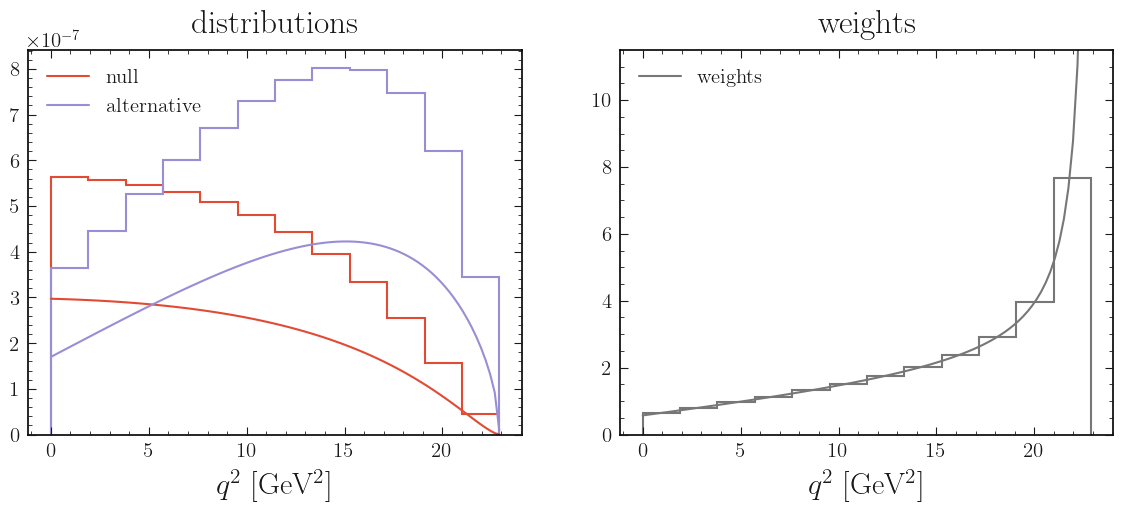

In [15]:
cvl = 5.
csl = 3.
ctl = 2.

pars = (cvl, csl, ctl,fp0, fp1, fp2, f01, f02, fT0, fT1, fT2)
lims = [0.0, 22.9]
labels = [r'$q^2$ [GeV$^2$]']
plot.dists(cmod, pars, lims, labels, plot_weights=True)

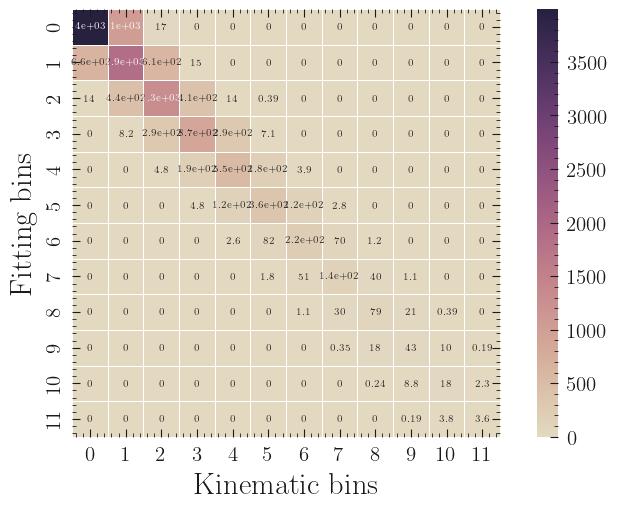

In [16]:
plot.map(cmod)

## Set up the model

In [17]:
spec = {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "theory",
                "type": "custom",
                "data":
                    {
                        "expr": "weight_function",
                        "ibin": [i for i in range(len(binning)-1)],
                    }
              }

model = modifier.add_to_model(model, ['singlechannel'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [5038.596218605799,
      3153.957968510615,
      2160.210744553253,
      1465.6218094461808,
      924.8580513940678,
      609.3609505410412,
      380.714282313377,
      233.53013623443695,
      132.05756104071642,
      72.31865769983669,
      29.03152034609114,
      7.521106885890091],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': [70.98306994351398,
        56.16011011839823,
        46.478067349592465,
        38.2834404076512,
        30.411478941249598,
        24.68523750222066,
        19.511901043039785,
        15.28169284583475,
        11.491630042805783,
        8.504037729210559,
        5.388090602995753,
        2.742463652610567]},
      {'name': 'theory',
       'type': 'custom',
       'data': {'expr': 'weight_function',
        'ibin': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}}]}]}]}

## Save and load model

In [18]:
modifier.save('knunu_model.json', model.spec, cmod, alt_yields)
model, alt_yields = modifier.load('knunu_model.json', alt.distribution, null.distribution, return_data=True)

data = alt_yields + model.config.auxdata

## Perform the fit

In [19]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']] = [True]

# pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
# best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


W MnPosDef Matrix forced pos-def by adding to diagonal 0.189869


{'cvl': array([4.8245399 , 0.18139505]),
 'csl': array([2.66572527, 0.44184693]),
 'ctl': array([2.34010481, 0.29847312]),
 'FF_decorrelated[0]': array([-0.29929573,  0.97406085]),
 'FF_decorrelated[1]': array([0.15157693, 0.98224433]),
 'FF_decorrelated[2]': array([0.16740561, 0.9842    ]),
 'FF_decorrelated[3]': array([-0.10812192,  0.98785631]),
 'FF_decorrelated[4]': array([0.03761505, 0.99253821]),
 'FF_decorrelated[5]': array([-0.02628145,  0.99287531]),
 'FF_decorrelated[6]': array([0.02612169, 0.99285401]),
 'FF_decorrelated[7]': array([0.0013402, 0.9933362]),
 'mu': array([1., 0.]),
 'stat': [[0.9907990062699279, 0.013554717837579555],
  [1.0185745449793857, 0.014568497923419632],
  [1.011448714386575, 0.017039462898565727],
  [0.982499063355268, 0.02022464585770789],
  [1.0003188964638767, 0.024324369114305855],
  [0.9814180448181374, 0.02845343492856367],
  [0.9814130898244647, 0.03422681196569016],
  [0.9950714137277822, 0.04230438059433511],
  [1.026394061530836, 0.0557816

In [20]:
best_fit_rot = cmod.rotate_pars({k:v[0] if len(np.shape(v))==1 else [p[0] for p in v] for k, v in best_fit_dict.items()})
best_fit_rot

{'cvl': 4.824539902569837,
 'csl': 2.6657252672832605,
 'ctl': 2.3401048071151362,
 'FF[0]': 0.3396468914492412,
 'FF[1]': -0.8736736138896949,
 'FF[2]': -0.10244138404673639,
 'FF[3]': 0.38749563277103827,
 'FF[4]': 0.1013476701783382,
 'FF[5]': 0.3351073572601921,
 'FF[6]': -0.8948761178557993,
 'FF[7]': -0.16008272508011662,
 'mu': 1.0,
 'stat': [0.9907990062699279,
  1.0185745449793857,
  1.011448714386575,
  0.982499063355268,
  1.0003188964638767,
  0.9814180448181374,
  0.9814130898244647,
  0.9950714137277822,
  1.026394061530836,
  0.9910594738621585,
  1.0614528086889488,
  1.0488780299209823]}

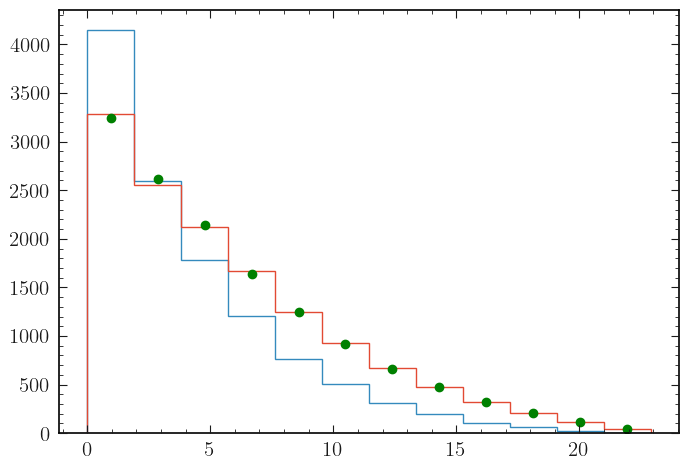

In [21]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit[:,0]), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, alt_yields, 'og')